<a href="https://colab.research.google.com/github/sholtodouglas/learning_from_play/blob/master/experimental/Generate_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb -q
!pip install pathy -q
!pip install comet_ml -q
!pip install umap-learn
!pip install natsorted

     |████████████████████████████████| 2.1MB 13.7MB/s 
     |████████████████████████████████| 163kB 48.6MB/s 
     |████████████████████████████████| 102kB 9.3MB/s 
     |████████████████████████████████| 133kB 53.9MB/s 
     |████████████████████████████████| 71kB 6.1MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
     |████████████████████████████████| 122kB 8.4MB/s 
     |████████████████████████████████| 266kB 18.0MB/s 
     |████████████████████████████████| 61kB 6.5MB/s 
     |████████████████████████████████| 522kB 43.5MB/s 
     |████████████████████████████████| 61kB 7.1MB/s 
     |████████████████████████████████| 81kB 6.1MB/s 
     |████████████████████████████████| 1.2MB 14.4MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=f605b04be164ff10610aa10e19d3f85b716644a41dece211962cfa8d3b6902c0
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel fo

In [ ]:
import requests
r = requests.get('https://ipinfo.io')
r.json()

{'city': 'Washington',
 'country': 'US',
 'hostname': '105.78.86.34.bc.googleusercontent.com',
 'ip': '34.86.78.105',
 'loc': '38.8951,-77.0364',
 'org': 'AS15169 Google LLC',
 'postal': '20045',
 'readme': 'https://ipinfo.io/missingauth',
 'region': 'Washington, D.C.',
 'timezone': 'America/New_York'}

In [ ]:
import argparse
from natsort import natsorted

parser = argparse.ArgumentParser(description='LFP training arguments')
parser.add_argument('run_name')
parser.add_argument('--train_datasets', nargs='+', help='Training dataset names')
parser.add_argument('--test_datasets', nargs='+', help='Testing dataset names')
parser.add_argument('-c', '--colab', default=False, action='store_true', help='Enable if using colab environment')
parser.add_argument('-s', '--data_source', default='DRIVE', help='Source of training data')
parser.add_argument('-tfr', '--from_tfrecords', default=False, action='store_true', help='Enable if using tfrecords format')
parser.add_argument('-d', '--device', default='TPU', help='Hardware device to train on')
parser.add_argument('-b', '--batch_size', default=512, type=int)
parser.add_argument('-wmax', '--window_size_max', default=40, type=int)
parser.add_argument('-wmin', '--window_size_min', default=20, type=int)
parser.add_argument('-la', '--actor_layer_size', default=2048, type=int, help='Layer size of actor, increases size of neural net')
parser.add_argument('-le', '--encoder_layer_size', default=512, type=int, help='Layer size of encoder, increases size of neural net')
parser.add_argument('-lp', '--planner_layer_size', default=512, type=int, help='Layer size of planner, increases size of neural net')
parser.add_argument('-embd', '--img_embedding_size', default=64, type=int, help='Embedding size of features,goal space')
parser.add_argument('-z', '--latent_dim', default=256, type=int, help='Size of the VAE latent space')
parser.add_argument('-g', '--gcbc', default=False, action='store_true', help='Enables GCBC, a simpler model with no encoder/planner')
parser.add_argument('-n', '--num_distribs', default=None, type=int, help='Number of distributions to use in logistic mixture model')
parser.add_argument('-q', '--qbits', default=None, type=int, help='Number of quantisation bits to discrete distributions into. Total quantisations = 2**qbits')
parser.add_argument('-lr', '--learning_rate', type=float, default=3e-4)
parser.add_argument('-t', '--train_steps', type=int, default=200000)
parser.add_argument('-r', '--resume', default=False, action='store_true')
parser.add_argument('-B', '--beta', type=float, default=0.00003)
parser.add_argument('-i', '--images', default=False, action='store_true')
parser.add_argument('--bucket_name', help='GCS bucket name to stream data from')
parser.add_argument('--tpu_name', help='GCP TPU name') # Only used in the script on GCP

### Sample local config
args = parser.parse_args('''
dummy_run 
--train_dataset UR5
--test_dataset UR5
-tfr
'''.split())

## Sample colab config
args = parser.parse_args('''
data
--train_dataset Unity/drawer_door_train
--test_dataset Unity/drawer_door_test
-c
-tfr
-s GCS
-d TPU
--bucket_name iowa_bucket_lfp
'''.split())

# ## Sample colab config
# args = parser.parse_args('''
# QuantB0_01
# --train_dataset UR5 UR5_slow_gripper UR5_high_transition
# --test_dataset UR5_slow_gripper_test
# -c
# -s DRIVE
# -d TPU
# -b 512
# -la 2048
# -le 512
# -lp 512
# -z 256
# -lr 3e-4
# -B 0.01
# -n 5
# -q 8
# '''.split())

print(args)

Namespace(actor_layer_size=2048, batch_size=512, beta=3e-05, bucket_name='iowa_bucket_lfp', colab=True, data_source='GCS', device='TPU', encoder_layer_size=512, from_tfrecords=True, gcbc=False, images=False, img_embedding_size=64, latent_dim=256, learning_rate=0.0003, num_distribs=None, planner_layer_size=512, qbits=None, resume=False, run_name='data', test_datasets=['Unity/drawer_door_test'], tpu_name=None, train_datasets=['Unity/drawer_door_train'], train_steps=200000, window_size_max=40, window_size_min=20)


In [ ]:
from pathlib import Path
from pathy import Pathy
import os
import requests
import json
import pprint
import logging
import numpy as np
import tensorflow as tf
import time



pp = pprint.PrettyPrinter(indent=4)
# In[4]:


#@title Workpace Setup (Local vs Colab)

# Set up working directory and libraries
if args.colab:
    from google.colab import drive, auth
    print('Using colab setup')
    WORKING_PATH = Path('/content/learning_from_play')
    # Clone repo
    try:
        get_ipython().system("git clone 'https://github.com/sholtodouglas/learning_from_play' {WORKING_PATH}")
    except: 
        pass
    # Mount drive
    drive.mount('/content/drive')
else:
    print('Using local setup')
    WORKING_PATH = Path.cwd()
    print(f'Working path: {WORKING_PATH}')

# Change working directory to learning_from_play
os.chdir(WORKING_PATH)
import lfp

# Set up storage directory and datasets
if args.data_source == 'DRIVE':
    assert args.colab, "Must be using Colab"
    print('Reading data from Google Drive')
    STORAGE_PATH = Path('/content/drive/My Drive/Robotic Learning')
elif args.data_source == 'GCS':
    if args.colab:
      auth.authenticate_user()
    print('Reading data from Google Cloud Storage')
    r = requests.get('https://ipinfo.io')
    region = r.json()['region']
    project_id = 'learning-from-play-303306'
    logging.warning(f'You are accessing GCS data from {region}, make sure this is the same as your bucket {args.bucket_name}')
    STORAGE_PATH = Pathy(f'gs://{args.bucket_name}')
else:
    print('Reading data from local filesystem')
    STORAGE_PATH = WORKING_PATH

print(f'Storage path: {STORAGE_PATH}')
TRAIN_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.train_datasets]
TEST_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.test_datasets]

Using colab setup
Cloning into '/content/learning_from_play'...
remote: Enumerating objects: 3045, done.
remote: Counting objects: 100% (565/565), done.
remote: Compressing objects: 100% (410/410), done.
remote: Total 3045 (delta 391), reused 283 (delta 154), pack-reused 2480
Receiving objects: 100% (3045/3045), 129.47 MiB | 17.78 MiB/s, done.
Resolving deltas: 100% (1869/1869), done.
Mounted at /content/drive
No pybullet installation found - which is fine if training


Reading data from Google Cloud Storage
Storage path: gs://iowa_bucket_lfp/


In [ ]:
TEST_DATA_PATHS[0]

Pathy('gs://iowa_bucket_lfp/data/Unity/drawer_door_test')

In [ ]:
os.listdir("/content/drive/MyDrive/Robotic Learning/data/")

['UR5',
 'UR5_high_transition',
 'UR5_high_transition_test',
 'UR5_slow_gripper',
 'UR5_slow_gripper_test',
 'Unity']

# Unzip files in drive

In [ ]:
! unzip ../drive/MyDrive/Robotic\ Learning/data/Unity/serv12Hz_test.zip -d /content/drive/MyDrive/Robotic\ Learning/data/Unity/

In [ ]:
! ls ../drive/MyDrive/Robotic\ Learning/data/Unity

 drawer_door_test       drawer_door_train   UR5_test	    UR5_test.zip
 drawer_door_test.zip   UR5_full_inc.zip   'UR5_test (1)'   UR5_train


In [ ]:
! rm -rf ../drive/MyDrive/Robotic\ Learning/data/Unity/drawer_door_test

In [ ]:
os.listdir('/content/drive/My Drive/Robotic Learning/data/Unity/')

['drawer_door_test.zip',
 'drawer_door_test',
 'drawer_door_train',
 'envHz25',
 'envHz25_test',
 'serv12Hz',
 'serv12Hz_test']

#Transfer files to GCP

In [ ]:
!gsutil -m cp -r ../drive/MyDrive/Robotic\ Learning/data/Unity* gs://lfp_europe_west4_a/data/

In [ ]:
!gsutil -m rsync -r -d gs://iowa_bucket_lfp/data/ gs://lfp_europe_west4_a/data/

Streaming output truncated to the last 5000 lines.
Copying gs://iowa_bucket_lfp/data/Unity/envHz25/states_and_ims/0/ims/8649_shoulder.jpg [Content-Type=image/jpeg]...
Copying gs://iowa_bucket_lfp/data/Unity/envHz25/states_and_ims/0/ims/864_gripper.jpg [Content-Type=image/jpeg]...
Copying gs://iowa_bucket_lfp/data/Unity/envHz25/states_and_ims/0/ims/864_shoulder.jpg [Content-Type=image/jpeg]...
Copying gs://iowa_bucket_lfp/data/Unity/envHz25/states_and_ims/0/ims/8650_gripper.jpg [Content-Type=image/jpeg]...
Copying gs://iowa_bucket_lfp/data/Unity/envHz25/states_and_ims/0/ims/8650_shoulder.jpg [Content-Type=image/jpeg]...
Copying gs://iowa_bucket_lfp/data/Unity/envHz25/states_and_ims/0/ims/8651_gripper.jpg [Content-Type=image/jpeg]...
Copying gs://iowa_bucket_lfp/data/Unity/envHz25/states_and_ims/0/ims/8651_shoulder.jpg [Content-Type=image/jpeg]...
Copying gs://iowa_bucket_lfp/data/Unity/envHz25/states_and_ims/0/ims/8652_gripper.jpg [Content-Type=image/jpeg]...
Copying gs://iowa_bucket_lf

# Generate TF records from Drive files

In [ ]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature


def transform_states(data):

    obs, acts, achieved_goals, sequence_index, sequence_id = data['obs'], data['acts'], data['achieved_goals'],  data['sequence_index'], data['sequence_id']

    img = tf.io.read_file(data['shoulder_im_path'])
    gripper_img = tf.io.read_file(data['gripper_im_path'])

    return {
            'obs': obs,
            'acts': acts,
            'achieved_goals': achieved_goals,
            'sequence_index': sequence_index,
            'sequence_id': sequence_id,
            'img':img,
            'gripper_img':gripper_img,
            }

def transform_dataset(dataset):
  return dataset.map(transform_states, num_parallel_calls=4)


def serialise(data):
    
    obs, acts, achieved_goals, sequence_index, sequence_id, img, gripper_img = data['obs'], data['acts'], data['achieved_goals'], data['sequence_index'], data['sequence_id'], data['img'], data['gripper_img']
    
    obs = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(obs).numpy(),]))
    acts = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(acts).numpy(),]))
    achieved_goals = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(achieved_goals).numpy(),])) 
    sequence_index =  Feature(int64_list=Int64List(value=[sequence_index[0],]))
    sequence_id = Feature(int64_list=Int64List(value=[sequence_id[0],]))
    img = Feature(bytes_list=BytesList(value=[img.numpy(),]))
    gripper_img = Feature(bytes_list=BytesList(value=[gripper_img.numpy(),]))
    # img is already serialised because we never decode it!
    
    features = Features(feature={
                'obs': obs,
                'acts': acts,
                'achieved_goals': achieved_goals,
                'sequence_index': sequence_index,
                'sequence_id': sequence_id,
                'img': img,
                'gripper_img':gripper_img,
                })
    
    example = Example(features=features)
    
    return example.SerializeToString()

In [ ]:
def decode_shoulder_img(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.reshape(image, [256,256, 3]) # explicit size needed for TPU
    return image

def decode_gripper_img(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.reshape(image, [64,64, 3]) # explicit size needed for TPU
    return image


def read_tfrecord(example):
    LABELED_TFREC_FORMAT = {
            'obs': tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'acts': tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'achieved_goals': tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'sequence_index': tf.io.FixedLenFeature([], tf.int64),
            'sequence_id': tf.io.FixedLenFeature([], tf.int64),
            'img': tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'gripper_img': tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
    }
    data = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    
    obs = tf.io.parse_tensor(data['obs'], tf.float32) 
    acts = tf.io.parse_tensor(data['acts'], tf.float32) 
    achieved_goals = tf.io.parse_tensor(data['achieved_goals'], tf.float32)  
    sequence_index = tf.cast(data['sequence_index'], tf.int32) 
    sequence_id = tf.cast(data['sequence_id'], tf.int32) # this is meant to be 32 even though you serialize as 64
    
    img = decode_shoulder_img(data['img'])
    gripper_img = decode_gripper_img(data['gripper_img'])

    return {'obs' : obs, 
            'acts' : acts, 
            'achieved_goals' : achieved_goals, 
            'sequence_index' : sequence_index, 
            'sequence_id' : sequence_id,
            'img' : img,
            'gripper_img': gripper_img}

def load_tf_records(filenames, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    # check, does this ignore intra order or just inter order? Both are an issue!
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=1) # automatically interleaves reads from multiple files - keep it at 1 we need the order
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:

paths =  TRAIN_DATA_PATHS
keys = ['obs','acts','achieved_goals']


for path in paths:
    obs_act_path = os.path.join(path, 'obs_act_etc/')
    
    try:
        os.makedirs(path/'tf_records')
    except:
        print('Files may already exist!')
        
    for demo in natsorted(os.listdir(obs_act_path)):
        print(obs_act_path+demo)
        
        dataset = {k:[] for k in keys+['sequence_index','sequence_id','im_path']}
        traj = np.load(obs_act_path+demo+'/data.npz')
        for k in keys:
            d = traj[k]
            if len(d.shape) < 2:
                d = np.expand_dims(d, axis = 1) # was N, should be N,1
            dataset[k] = d.astype(np.float32)
        timesteps = len(traj['obs'])
        dataset['sequence_index']= np.arange(timesteps, dtype=np.int32).reshape(-1, 1)
        dataset['sequence_id'] = np.full(timesteps, fill_value=int(demo), dtype=np.int32).reshape(-1, 1)
        dataset['im_path'] = [str(path) for i in range(0,timesteps)]
        dataset['shoulder_im_path'] = [str(s) + '/states_and_ims/'+str(dataset['sequence_id'][i][0]) + '/ims/'+str(dataset['sequence_index'][i][0])+'_shoulder.jpg' for i,s in enumerate(dataset['im_path'])]
        dataset['gripper_im_path'] = [str(s) + '/states_and_ims/'+str(dataset['sequence_id'][i][0]) + '/ims/'+str(dataset['sequence_index'][i][0])+'_gripper.jpg' for i,s in enumerate(dataset['im_path'])]
        full_dataset = tf.data.Dataset.from_tensor_slices(dataset)
        full_dataset = transform_dataset(full_dataset)
        it = iter(full_dataset)

        # Write the records to a file.
        with tf.io.TFRecordWriter(str(path/'tf_records/')+f"/{demo}.tfrecords") as file_writer:
            for data in it:
                byte_stream = serialise(data)
                file_writer.write(byte_stream)


/content/drive/My Drive/Robotic Learning/data/Unity/drawer_door_train/obs_act_etc/0


# Where we precompute and save those

In [ ]:
dl = lfp.data.PlayDataloader(include_imgs = args.images, batch_size=1,  window_size=args.window_size_max, min_window_size=args.window_size_min)

In [ ]:
# Train data
train_data = dl.extract(TRAIN_DATA_PATHS, from_tfrecords=args.from_tfrecords)
train_dataset = dl.load(train_data)

{   'acts': TensorSpec(shape=(1, 40, 7), dtype=tf.float32, name=None),
    'dataset_path': TensorSpec(shape=(1, None), dtype=tf.int32, name=None),
    'goal_imgs': TensorSpec(shape=(1, 40, 200, 200, 3), dtype=tf.uint8, name=None),
    'goals': TensorSpec(shape=(1, 40, 11), dtype=tf.float32, name=None),
    'imgs': TensorSpec(shape=(1, 40, 200, 200, 3), dtype=tf.uint8, name=None),
    'masks': TensorSpec(shape=(1, 40), dtype=tf.float32, name=None),
    'obs': TensorSpec(shape=(1, 40, 18), dtype=tf.float32, name=None),
    'proprioceptive_features': TensorSpec(shape=(1, 40, 7), dtype=tf.float32, name=None),
    'seq_lens': TensorSpec(shape=(1,), dtype=tf.float32, name=None),
    'tstep_idxs': TensorSpec(shape=(1, None), dtype=tf.int32, name=None)}


In [ ]:
t_it = iter(train_dataset)


In [ ]:
import time

In [ ]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature

def serialise(data):
    
    obs, acts, goals, seq_lens, masks, dataset_path, tstep_idxs , imgs , goal_imgs, proprioceptive_features = data['obs'], \
    data['acts'], data['goals'], data['seq_lens'], data['masks'], data['dataset_path'], data['tstep_idxs'], data['imgs'], data['goal_imgs'], data['proprioceptive_features']
    
    # obs (1, 40, 18)
    # acts (1, 40, 7)
    # goals (1, 40, 11)
    # seq_lens (1,)
    # masks (1, 40)
    # dataset_path (1, 40)
    # tstep_idxs (1, 40)
    # imgs (1, 40, 200, 200, 3)
    # goal_imgs (1, 40, 200, 200, 3)
    # proprioceptive_features (1, 40, 7)

    goal_imgs = tf.expand_dims(goal_imgs[:,0,:,:,:],1) # crete a :, 1, :,:,: shaped goal images for less file IO

    
    obs = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(obs).numpy(),]))
    acts = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(acts).numpy(),]))
    goals = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(goals).numpy(),])) 
    seq_lens = Feature(int64_list=Int64List(value=[seq_lens,]))
    masks = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(masks).numpy(),])) 

    imgs = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(imgs).numpy(),]))
    goal_imgs = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(goal_imgs).numpy(),]))
    proprioceptive_features = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(proprioceptive_features).numpy(),]))

    
    features = Features(feature={
              'obs':obs,
              'acts':acts,
              'goals':goals,
              'seq_lens':seq_lens,
              'masks':masks,
              'imgs':imgs,
              'goal_imgs':goal_imgs,
              'proprioceptive_features':proprioceptive_features})
    
    example = Example(features=features)
    
    return example.SerializeToString()


In [ ]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    #image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [200,200, 3]) # explicit size needed for TPU
    return image

def read_tfrecord(example):
    LABELED_TFREC_FORMAT = {
            'obs':tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'acts':tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'goals':tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'seq_lens':tf.io.FixedLenFeature([], tf.int64),
            'masks':tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'imgs':tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'goal_imgs':tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'proprioceptive_features':tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
    }
    data = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    
    obs = tf.io.parse_tensor(data['obs'], tf.float32) 
    acts = tf.io.parse_tensor(data['acts'], tf.float32) 
    goals = tf.io.parse_tensor(data['goals'], tf.float32)  
    seq_lens = tf.cast(data['seq_lens'], tf.int32) # this is meant to be 32 even though you serialize as 64
    masks = tf.io.parse_tensor(data['masks'], tf.float32) 
    imgs = tf.io.parse_tensor(data['imgs'], tf.uint8)   
    goal_imgs = tf.io.parse_tensor(data['goal_imgs'], tf.uint8)   
    proprioceptive_features =tf.io.parse_tensor( data['proprioceptive_features'], tf.float32) 

    
    # img = decode_image(data['img'])

    return {  'obs':obs,
              'acts':acts,
              'goals':goals,
              'seq_lens':seq_lens,
              'masks':masks,
              'imgs':imgs,
              'goal_imgs':goal_imgs,
              'proprioceptive_features':proprioceptive_features}

In [ ]:
data_paths = [str(STORAGE_PATH/'precompute')+f"/{x}.tfrecords" for x in range(0,23)]

In [ ]:


for path in data_paths:
  with tf.io.TFRecordWriter(path) as file_writer:
    print(path)
    for i in range(0,10):
        byte_stream = serialise(t_it.next())
        file_writer.write(byte_stream)

gs://lfp_europe_west4_a/precompute/0.tfrecords
gs://lfp_europe_west4_a/precompute/1.tfrecords
gs://lfp_europe_west4_a/precompute/2.tfrecords
gs://lfp_europe_west4_a/precompute/3.tfrecords
gs://lfp_europe_west4_a/precompute/4.tfrecords
gs://lfp_europe_west4_a/precompute/5.tfrecords
gs://lfp_europe_west4_a/precompute/6.tfrecords
gs://lfp_europe_west4_a/precompute/7.tfrecords
gs://lfp_europe_west4_a/precompute/8.tfrecords
gs://lfp_europe_west4_a/precompute/9.tfrecords
gs://lfp_europe_west4_a/precompute/10.tfrecords
gs://lfp_europe_west4_a/precompute/11.tfrecords
gs://lfp_europe_west4_a/precompute/12.tfrecords
gs://lfp_europe_west4_a/precompute/13.tfrecords
gs://lfp_europe_west4_a/precompute/14.tfrecords


KeyboardInterrupt: ignored

In [ ]:
# What about we try making a super dataset?

#What about we try make a super dataset 1 TFR?

In [ ]:
import glob
import tensorflow as tf
import os
import numpy as np
from natsort import natsorted
import sklearn
import pprint
from tqdm import tqdm
import attr 

pp = pprint.PrettyPrinter(indent=4)


def read_tfrecord(include_imgs=False):
    def read_tfrecord_helper(example):
        LABELED_TFREC_FORMAT = {
                'obs': tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
                'acts': tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
                'achieved_goals': tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
                'joint_poses': tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
                'target_poses': tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
                'acts_quat': tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
                'acts_rpy_rel': tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
                'velocities': tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
                'obs_quat': tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
                'proprioception': tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
                'sequence_index': tf.io.FixedLenFeature([], tf.int64),
                'sequence_id': tf.io.FixedLenFeature([], tf.int64),
        }
        if include_imgs:
            LABELED_TFREC_FORMAT['img'] = tf.io.FixedLenFeature([], tf.string) # tf.string means bytestring

        data = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)

        output = {}
        output['obs'] = data['obs']
        output['acts'] = data['acts']
        output['achieved_goals'] = data['achieved_goals']
        output['joint_poses'] = data['joint_poses']
        output['target_poses'] = data['target_poses']
        output['acts_quat'] =  data['acts_quat']
        output['acts_rpy_rel'] = data['acts_rpy_rel']
        output['velocities'] = data['velocities']
        output['obs_quat'] = data['obs_quat']
        output['proprioception'] = data['proprioception']
        output['sequence_index'] = data['sequence_index']
        output['sequence_id'] = data['sequence_id']
        output['img'] = data['img']

        # output = {}
        # output['obs'] = tf.ensure_shape(tf.io.parse_tensor(data['obs'], tf.float32), (18,))
        # output['acts'] = tf.ensure_shape(tf.io.parse_tensor(data['acts'], tf.float32), (7,))
        # output['achieved_goals'] = tf.ensure_shape(tf.io.parse_tensor(data['achieved_goals'], tf.float32), (11,))
        # output['joint_poses'] = tf.ensure_shape(tf.io.parse_tensor(data['joint_poses'], tf.float32), (8,))
        # output['target_poses'] = tf.ensure_shape(tf.io.parse_tensor(data['target_poses'], tf.float32), (6,))
        # output['acts_quat'] = tf.ensure_shape(tf.io.parse_tensor( data['acts_quat'], tf.float32), (8,))
        # output['acts_rpy_rel'] = tf.ensure_shape(tf.io.parse_tensor(data['acts_rpy_rel'], tf.float32), (7,))
        # output['velocities'] = tf.ensure_shape(tf.io.parse_tensor(data['velocities'], tf.float32), (6,))
        # output['obs_quat'] = tf.ensure_shape(tf.io.parse_tensor(data['obs_quat'], tf.float32), (19,))
        # output['proprioception'] = tf.ensure_shape(tf.io.parse_tensor(data['proprioception'], tf.float32), (1,))
        # output['sequence_index'] = tf.cast(data['sequence_index'], tf.int32)
        # output['sequence_id'] = tf.cast(data['sequence_id'], tf.int32) # this is meant to be 32 even though you serialize as 64
        # if include_imgs:
        #     output['img'] = decode_image(data['img'])

        return output
    return read_tfrecord_helper

def extract_tfrecords(paths, include_imgs=True, ordered=True, num_parallel_reads=1):
    # In our case, order does matter
    tf_options = tf.data.Options()
    tf_options.experimental_deterministic = ordered  # must be 1 to maintain order while streaming from GCS

    dataset = tf.data.TFRecordDataset(paths, num_parallel_reads=num_parallel_reads)
    dataset = dataset.with_options(tf_options)
    dataset = dataset.map(read_tfrecord(include_imgs), num_parallel_calls=num_parallel_reads)
    return dataset

In [ ]:
record_paths = []
for p in TRAIN_DATA_PATHS:
    record_paths += tf.io.gfile.glob(str(p/'tf_records/*.tfrecords'))
d = extract_tfrecords(record_paths)

In [ ]:
it = iter(d)
d1 = it.next()

In [ ]:
d1

{'achieved_goals': <tf.Tensor: shape=(), dtype=string, numpy=b'\x08\x01\x12\x04\x12\x02\x08\x0b",\x1eZ\xd3\xbd\xd7\xaeG=\x86}-\xb7l\xe1\xa7)7\xd3p\xa8\xeb!\x9d)\x00\x00\x80?\xb4\x7f\x08#\x00\x00\x00\x00h\xae\xd3<\x00\x00\x00\x00'>,
 'acts': <tf.Tensor: shape=(), dtype=string, numpy=b'\x08\x01\x12\x04\x12\x02\x08\x07"\x1c\xf8\xae\x81\xbdb5\xc4=\xf5?\x7f>PH(=\xa1N\xd3\xbe\xf7\xfd\xce?\x00\x00\x00\x00'>,
 'acts_quat': <tf.Tensor: shape=(), dtype=string, numpy=b'\x08\x01\x12\x04\x12\x02\x08\x08" \xf8\xae\x81\xbdb5\xc4=\xf5?\x7f>\x8a\xf0%>\x00\xf6\x01\xbe\xe6\xf05?/6,?\x00\x00\x00\x00'>,
 'acts_rpy_rel': <tf.Tensor: shape=(), dtype=string, numpy=b'\x08\x01\x12\x04\x12\x02\x08\x07"\x1c\xe4\xdd\x03\xbc,v,\xbdP\x05V\xbc\x97\xfb\x1e=\xc2\xd5\xd6\xbel\xfb\xce?\x00\x00\x00\x00'>,
 'img': <tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x1

In [ ]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature

def serialise(data):
    
    obs, acts, achieved_goals, joint_poses, target_poses, acts_quat, acts_rpy_rel, velocities, obs_quat, sequence_index, sequence_id, img , proprioception = data['obs'], data['acts'], data['achieved_goals'], data['joint_poses'], data['target_poses'], data['acts_quat'], data['acts_rpy_rel'], data['velocities'], data['obs_quat'], data['sequence_index'], data['sequence_id'], data['img'], data['proprioception']
    obs = Feature(bytes_list=BytesList(value=[obs.numpy(),]))
    acts = Feature(bytes_list=BytesList(value=[acts.numpy(),]))
    achieved_goals = Feature(bytes_list=BytesList(value=[achieved_goals.numpy(),])) 
    joint_poses = Feature(bytes_list=BytesList(value=[joint_poses.numpy(),])) 
    target_poses = Feature(bytes_list=BytesList(value=[target_poses.numpy(),]))
    acts_quat = Feature(bytes_list=BytesList(value=[acts_quat.numpy(),]))
    acts_rpy_rel = Feature(bytes_list=BytesList(value=[acts_rpy_rel.numpy(),])) 
    velocities = Feature(bytes_list=BytesList(value=[velocities.numpy(),])) 
    obs_quat = Feature(bytes_list=BytesList(value=[obs_quat.numpy(),]))
    proprioception = Feature(bytes_list=BytesList(value=[proprioception.numpy(),])) 
    sequence_index =  Feature(int64_list=Int64List(value=[sequence_index.numpy(),]))
    sequence_id = Feature(int64_list=Int64List(value=[sequence_id.numpy(),]))
    img = Feature(bytes_list=BytesList(value=[img.numpy(),]))
    # img is already serialised because we never decode it!
    
    features = Features(feature={
                'obs': obs,
                'acts': acts,
                'achieved_goals': achieved_goals,
                'joint_poses': joint_poses,
                'target_poses': target_poses,
                'acts_quat': acts_quat,
                'acts_rpy_rel': acts_rpy_rel,
                'velocities': velocities,
                'obs_quat': obs_quat,
                'proprioception': proprioception,
                'sequence_index': sequence_index,
                'sequence_id': sequence_id,
                'img': img,
                })
    
    example = Example(features=features)
    
    return example.SerializeToString()

In [ ]:
# Write the records to a file.
from tqdm import tqdm_notebook
counter = 0
i = 0
path = str(STORAGE_PATH/'unified/tf_records')+f"/{counter}.tfrecords"
path
it = iter(d)
with tf.io.TFRecordWriter(path) as file_writer:
      for data in tqdm_notebook(it):
          byte_stream = serialise(data)
          file_writer.write(byte_stream)
          i += 1
          if (i>0) and (i % 25000 == 0):
            counter += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':

753it [00:32, 46.41it/s]

In [ ]:
serialise(d1)

b'\n\xc1;\n:\n\x0cacts_rpy_rel\x12*\n(\n&\x08\x01\x12\x04\x12\x02\x08\x07"\x1c\xe4\xdd\x03\xbc,v,\xbdP\x05V\xbc\x97\xfb\x1e=\xc2\xd5\xd6\xbel\xfb\xce?\x00\x00\x00\x00\n4\n\nvelocities\x12&\n$\n"\x08\x01\x12\x04\x12\x02\x08\x06"\x18\x86m\xa6;\x87\xa0{\xba\x9cx\x82\xbb=\xa7\xeb\xbb\xa6\x0e\xcb\xbc\x96\xc1\xa6\xb9\n2\n\x04acts\x12*\n(\n&\x08\x01\x12\x04\x12\x02\x08\x07"\x1c\xf8\xae\x81\xbdb5\xc4=\xf5?\x7f>PH(=\xa1N\xd3\xbe\xf7\xfd\xce?\x00\x00\x00\x00\nL\n\x0eachieved_goals\x12:\n8\n6\x08\x01\x12\x04\x12\x02\x08\x0b",\x1eZ\xd3\xbd\xd7\xaeG=\x86}-\xb7l\xe1\xa7)7\xd3p\xa8\xeb!\x9d)\x00\x00\x80?\xb4\x7f\x08#\x00\x00\x00\x00h\xae\xd3<\x00\x00\x00\x00\n\x14\n\x0bsequence_id\x12\x05\x1a\x03\n\x01\x00\nf\n\x08obs_quat\x12Z\nX\nV\x08\x01\x12\x04\x12\x02\x08\x13"Lwfb\xbd<8\r>%P\x86>\xd4\xc6\x94:\xe1\xc8a;\x82W\x128\x92\xff\x7f?\xef\xa5\xcd\xb6\x1eZ\xd3\xbd\xd7\xaeG=\x86}-\xb7l\xe1\xa7)7\xd3p\xa8\xeb!\x9d)\x00\x00\x80?\xb4\x7f\x08#\x00\x00\x00\x00h\xae\xd3<\x00\x00\x00\x00\n6\n\x0ctarget_poses\x12&

In [ ]:
record_paths = tf.io.gfile.glob(str(STORAGE_PATH/'unified/tf_records/*.tfrecords'))
d2 = extract_tfrecords(record_paths)

In [ ]:
it = iter(d2)

In [ ]:
c= 0
for i in it:
  c += 1
  if c % 1000 == 0:
    print(c, i['sequence_id'].numpy(), i['sequence_index'].numpy())

# d1_copy = it.next()
# d1_copy

1000 0 999
2000 0 1999
3000 0 2999
4000 1 682
5000 1 1682
6000 1 2682
7000 1 3682
8000 1 4682
9000 1 5682
10000 10 804
11000 10 1804
12000 10 2804
13000 10 3804
14000 10 4804
15000 10 5804
16000 11 198
17000 11 1198
18000 11 2198
19000 11 3198
20000 11 4198
21000 11 5198
22000 12 528
23000 12 1528
24000 12 2528
25000 13 830
26000 13 1830
27000 14 168
28000 14 1168
29000 14 2168
30000 14 3168
31000 14 4168
32000 14 5168
33000 14 6168
34000 14 7168
35000 14 8168
36000 14 9168
37000 15 839
38000 15 1839
39000 15 2839
40000 15 3839
41000 15 4839
42000 15 5839
43000 15 6839
44000 15 7839
45000 15 8839
46000 15 9839
47000 15 10839
48000 15 11839
49000 15 12839
50000 15 13839
51000 15 14839
52000 15 15839
53000 15 16839
54000 16 658
55000 16 1658
56000 16 2658
57000 16 3658
58000 16 4658
59000 16 5658
60000 16 6658
61000 16 7658
62000 17 156
63000 18 629
64000 18 1629
65000 18 2629
66000 18 3629
67000 18 4629
68000 18 5629
69000 18 6629
70000 18 7629
71000 19 954
72000 2 831
73000 2 1831
7400

In [ ]:
for k,v in d1.items():
  print(d1_copy[k].numpy() == v.numpy())

False
False
False
False
False
False
False
False
False
True
False
True
False


In [ ]:
batch_size = 16
def load_tf_records(filenames, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    # check, does this ignore intra order or just inter order? Both are an issue!
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=60) # automatically interleaves reads from multiple files - keep it at 1 we need the order
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_tfrecord, num_parallel_calls=600)
    dataset =   dataset.repeat()\
                .batch(batch_size, drop_remainder=True)\
                # .prefetch(dl.prefetch_size)
    return dataset



In [ ]:
data_paths = [str(STORAGE_PATH/'precompute')+f"/{x}.tfrecords" for x in range(0,13)]
d =load_tf_records(data_paths, ordered=False)#['/home/sholto/Desktop/AI/learning_from_play/data/UR5_high_transition/tf_records/21.tfrecords'], ordered=True) #record_paths
print(d)
d = iter(d)
x = d.next()

<BatchDataset shapes: {obs: <unknown>, acts: <unknown>, goals: <unknown>, seq_lens: (16,), masks: <unknown>, imgs: <unknown>, goal_imgs: <unknown>, proprioceptive_features: <unknown>}, types: {obs: tf.float32, acts: tf.float32, goals: tf.float32, seq_lens: tf.int32, masks: tf.float32, imgs: tf.uint8, goal_imgs: tf.uint8, proprioceptive_features: tf.float32}>


In [ ]:
t = time.time()
for i in range(0,10):
  # print(i)
  x = d.next()
print(time.time()-t)

1.0041556358337402


In [ ]:
dl = lfp.data.PlayDataloader(include_imgs = args.images, batch_size=batch_size,  window_size=args.window_size_max, min_window_size=args.window_size_min)
train_data = dl.extract(TRAIN_DATA_PATHS, from_tfrecords=args.from_tfrecords)
train_dataset = dl.load(train_data)
test_it = iter(train_dataset)

{   'acts': TensorSpec(shape=(16, 40, 7), dtype=tf.float32, name=None),
    'dataset_path': TensorSpec(shape=(16, None), dtype=tf.int32, name=None),
    'goal_imgs': TensorSpec(shape=(16, 40, 200, 200, 3), dtype=tf.uint8, name=None),
    'goals': TensorSpec(shape=(16, 40, 11), dtype=tf.float32, name=None),
    'imgs': TensorSpec(shape=(16, 40, 200, 200, 3), dtype=tf.uint8, name=None),
    'masks': TensorSpec(shape=(16, 40), dtype=tf.float32, name=None),
    'obs': TensorSpec(shape=(16, 40, 18), dtype=tf.float32, name=None),
    'proprioceptive_features': TensorSpec(shape=(16, 40, 7), dtype=tf.float32, name=None),
    'seq_lens': TensorSpec(shape=(16,), dtype=tf.float32, name=None),
    'tstep_idxs': TensorSpec(shape=(16, None), dtype=tf.int32, name=None)}
4.210890531539917


In [ ]:
t = time.time()
for i in range(0,10):
  test_it.next()
print(time.time()-t)

0.0570371150970459


In [ ]:
for i in range(0, 100):
  example = t_it.next()

In [ ]:
# np.frombuffer(example['goal_imgs'].numpy().tobytes(), np.uint8)

In [ ]:
bstr = serialise(example)

In [ ]:
d = read_tfrecord(bstr)

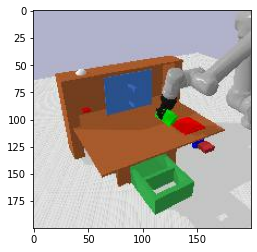

In [ ]:
import matplotlib.pyplot as plt 
plt.imshow(d['imgs'][0,15])

In [ ]:


def load_tf_records(filenames, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    # check, does this ignore intra order or just inter order? Both are an issue!
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.experimental.AUTOTUNE) # automatically interleaves reads from multiple files - keep it at 1 we need the order
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

d =load_dataset([record_paths], ordered=True)#['/home/sholto/Desktop/AI/learning_from_play/data/UR5_high_transition/tf_records/21.tfrecords'], ordered=True) #record_paths
print(d)
d = iter(d)

In [ ]:
for k,v in example.items():
  print(k, v.shape)

In [ ]:
d





with tf.io.TFRecordWriter(str(path/'tf_records/')+f"/{demo}.tfrecords") as file_writer:
            for data in it:
                byte_stream = serialise(data)
                file_writer.write(byte_stream)

In [ ]:
import subprocess
ll = args.train_datasets
print(ll)
files = []
for l in ll :
  files.append(tf.io.gfile.glob(f'gs://lfp_europe_west4_a/data/{l}/tf_records/*.tfrecords'))
  print(len(files))


def done(files):
  for l in files:
    if len(l) > 0:
      return False
  return True

counter = 0
while not done(files):
  for l in files:
    if len(l) > 0:
      r = l.pop()
      list_files = subprocess.run(["gsutil", "cp", r, f"gs://lfp_europe_west4_a/data/combined/tf_records/{counter}.tfrecords"])
      counter += 1
      print(r)

gs://lfp_europe_west4_a/data/UR5/tf_records/9.tfrecords
gs://lfp_europe_west4_a/data/UR5_slow_gripper/tf_records/9.tfrecords
gs://lfp_europe_west4_a/data/UR5_high_transition/tf_records/9.tfrecords
gs://lfp_europe_west4_a/data/UR5/tf_records/8.tfrecords
gs://lfp_europe_west4_a/data/UR5_slow_gripper/tf_records/8.tfrecords
gs://lfp_europe_west4_a/data/UR5_high_transition/tf_records/8.tfrecords
gs://lfp_europe_west4_a/data/UR5/tf_records/7.tfrecords
gs://lfp_europe_west4_a/data/UR5_slow_gripper/tf_records/7.tfrecords
gs://lfp_europe_west4_a/data/UR5_high_transition/tf_records/7.tfrecords
gs://lfp_europe_west4_a/data/UR5/tf_records/6.tfrecords
gs://lfp_europe_west4_a/data/UR5_slow_gripper/tf_records/6.tfrecords
gs://lfp_europe_west4_a/data/UR5_high_transition/tf_records/6.tfrecords
gs://lfp_europe_west4_a/data/UR5/tf_records/51.tfrecords
gs://lfp_europe_west4_a/data/UR5_slow_gripper/tf_records/5.tfrecords
gs://lfp_europe_west4_a/data/UR5_high_transition/tf_records/5.tfrecords
gs://lfp_europ